# Potato Diseases

by Rahma Hayuning Astuti

In [ ]:
# libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import sklearn
import PIL
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from sklearn.model_selection import train_test_split

In [ ]:
#load the data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

The original dataset doesn't get splitted. So, I did it. I splitted the data into:

train = 0.7
test = 0.15
val = 0.15

For script, you can take a look at `split_dataset.py`

In [ ]:
#path for dataset
data_dir = "/content/drive/MyDrive/potato-diseases/data/split_dataset"
train_dir = "/content/drive/MyDrive/potato-diseases/data/split_dataset/train"
test_dir = "/content/drive/MyDrive/potato-diseases/data/split_dataset/test"
val_dir = "/content/drive/MyDrive/potato-diseases/data/split_dataset/val"

now, let's see of the image in dataset (train)

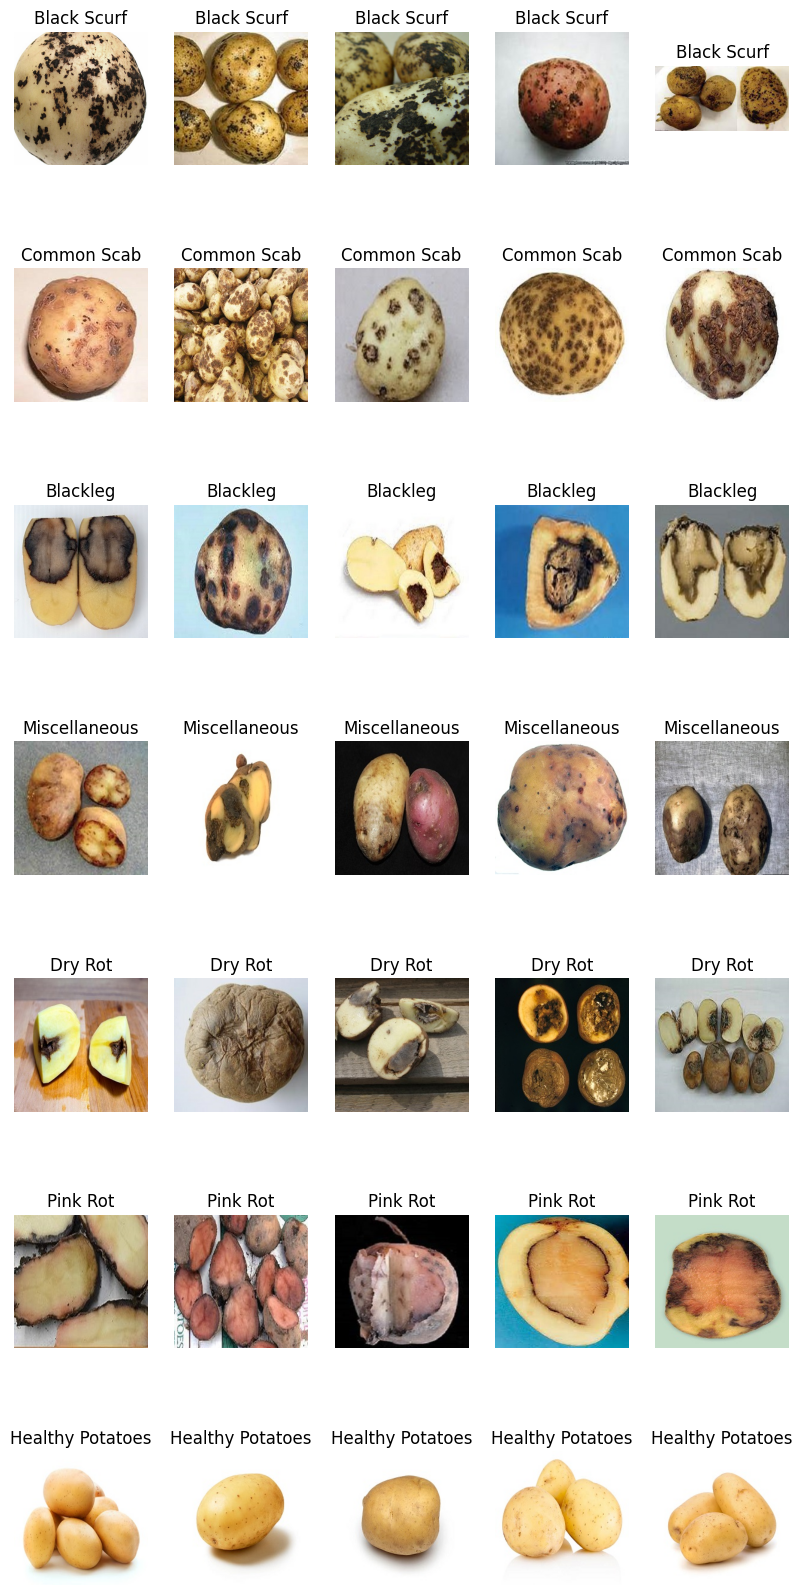

In [ ]:
# Function to load and plot images
def plot_images(root_dir, num_images=5):
    # Get the list of subfolders
    subfolders = []
    for f in os.listdir(root_dir):
        if os.path.isdir(os.path.join(root_dir, f)):
            subfolders.append(f)

    num_subfolders = len(subfolders)

    # Create subplots
    fig, axes = plt.subplots(nrows=num_subfolders,
                             ncols=num_images,
                             figsize=(10, 3 * num_subfolders))

    # Iterate through subfolders
    for i, subfolder in enumerate(subfolders):
        subfolder_path = os.path.join(root_dir, subfolder)

        # Get the list of image files in the subfolder
        img_files = []
        for f in os.listdir(subfolder_path):
          if f.endswith('.jpg'):
            img_files.append(f)

        # Plot the first 'num_images' images from each subfolder
        for j in range(num_images):
            img_path = os.path.join(subfolder_path, img_files[j])
            img = mpimg.imread(img_path)

            # Plot the image
            axes[i, j].imshow(img)
            axes[i, j].set_title(subfolder)
            axes[i, j].axis('off')

    plt.show()

# call the function
plot_images(train_dir, num_images=5)


In [ ]:
#check how many clases we have in this dataset
for c, i in enumerate(os.listdir(train_dir)):
  print("class %i: %s" %(c,i))

class 0: Black Scurf
class 1: Common Scab
class 2: Blackleg
class 3: Miscellaneous
class 4: Dry Rot
class 5: Pink Rot
class 6: Healthy Potatoes


So, we have 7 multi-classes in the dataset

plot distribution



In [ ]:
def plot_data(directory):
  class_folders = os.listdir(directory)

  # to store the count of images in each class
  class_images_count = {}

  # Loop through each class folder and count the images
  for class_folder in class_folders:
      class_path = os.path.join(directory, class_folder)
      if os.path.isdir(class_path):
          # Count the images in the class folder
          class_count = len(os.listdir(class_path))

          # Store the count in the dictionary
          class_images_count[class_folder] = class_count


  # Plot the distribution
  plt.figure(figsize=(10, 6))
  bars = plt.bar(class_images_count.keys(), class_images_count.values(), color='coral')
  plt.xlabel('Class')
  plt.ylabel('Number of Images')
  plt.title('Distribution of Images in Each Class')
  plt.xticks(rotation=45, ha='right')

  # Add value labels on top of each bar
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

  plt.show()


=======================Train====================


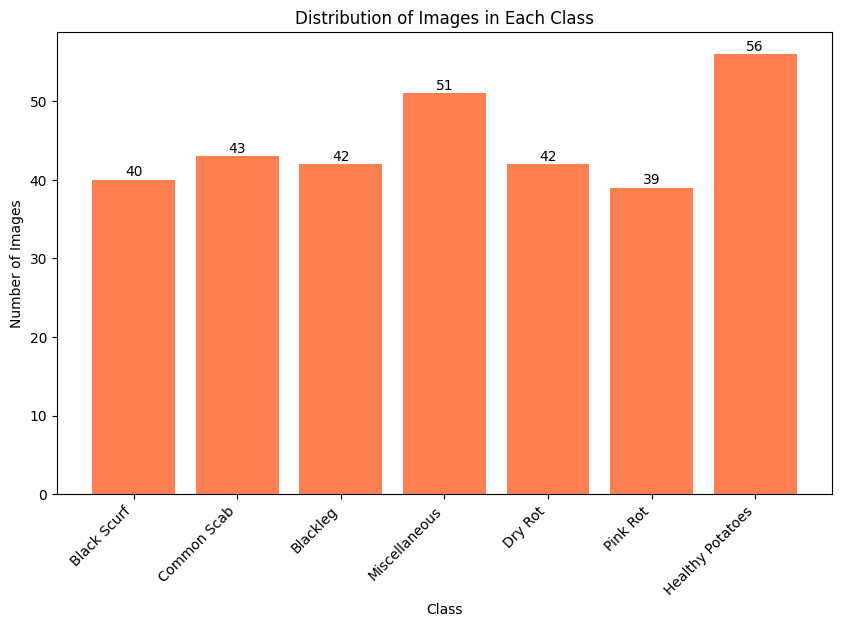

In [ ]:
print("=======================Train====================")
train_plot = plot_data(train_dir)

=========================Test====================


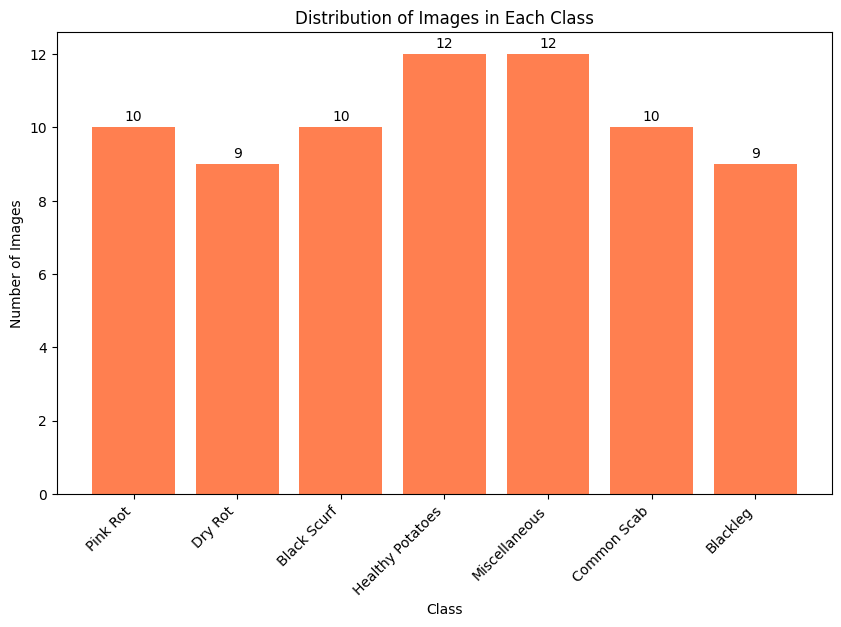

In [ ]:
print("=========================Test====================")
test_plot = plot_data(test_dir)

=======================Validation====================


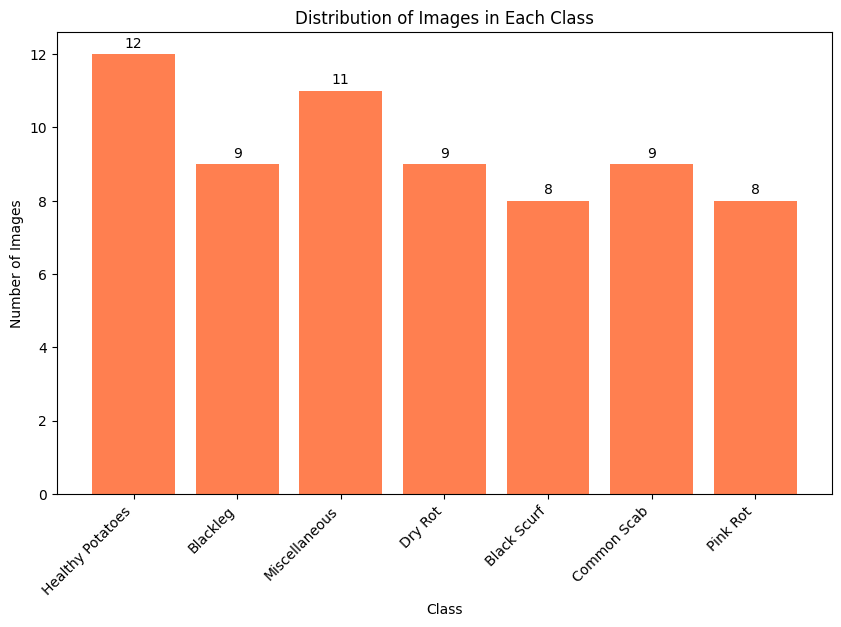

In [ ]:
print("=======================Validation====================")
val_plot = plot_data(val_dir)

### Data Augmentation

In [ ]:
#train dataset
train_datagen = ImageDataGenerator(
    rescale=1./127.5 - 1.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    vertical_flip=True,
    )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=20,
)


Found 313 images belonging to 7 classes.


In [ ]:
#validation
val_datagen = ImageDataGenerator(rescale=1./127.5 - 1.0)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=20,
    shuffle = False
)

Found 66 images belonging to 7 classes.


## Model

I will use MobileNetV2 because it has small size and good result based on https://keras.io/api/applications/

In [ ]:
base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3))

#only want vector representations
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


Now we will train new model with different types of learning rate

### Adjusting learning rate


In [ ]:
def make_model(learning_rate=0.01):
  ##############################
  #Architecture of model

  inputs = keras.Input(shape=(224, 224, 3))
  base = base_model(inputs, training = False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  outputs = keras.layers.Dense(7)(vectors)
  model = keras.Model(inputs, outputs)

  ##############################

  learning_rate = 0.01
  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  loss= keras.losses.CategoricalCrossentropy(from_logits=True)
  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
      )
  return model

In [ ]:
scores={}

for lr in [0.001, 0.01, 0.1]:
  print(lr)
  model = make_model(learning_rate=lr)
  history = model.fit(
      train_generator,
      epochs = 15,
      validation_data=val_generator)
  scores[lr] = history.history

  print()
  print()

0.001
Epoch 1/15
16/16 [==============================] - 91s 5s/step - loss: 2.8446 - accuracy: 0.2684 - val_loss: 1.9334 - val_accuracy: 0.4091
Epoch 2/15
16/16 [==============================] - 7s 427ms/step - loss: 1.7723 - accuracy: 0.4537 - val_loss: 1.8683 - val_accuracy: 0.4697
Epoch 3/15
16/16 [==============================] - 7s 402ms/step - loss: 1.3728 - accuracy: 0.4984 - val_loss: 1.8611 - val_accuracy: 0.4394
Epoch 4/15
16/16 [==============================] - 6s 350ms/step - loss: 1.1799 - accuracy: 0.5751 - val_loss: 1.6284 - val_accuracy: 0.5152
Epoch 5/15
16/16 [==============================] - 8s 494ms/step - loss: 1.1956 - accuracy: 0.6102 - val_loss: 1.6132 - val_accuracy: 0.4545
Epoch 6/15
16/16 [==============================] - 6s 353ms/step - loss: 1.2055 - accuracy: 0.5783 - val_loss: 1.5901 - val_accuracy: 0.5000
Epoch 7/15
16/16 [==============================] - 6s 380ms/step - loss: 1.2516 - accuracy: 0.5847 - val_loss: 1.9331 - val_accuracy: 0.4242
Ep

It has good results but also overfitting at the same time

In [ ]:
for lr, hist in scores.items():
  print(lr)
  print(hist)

0.001
{'loss': [2.844623327255249, 1.7722615003585815, 1.3728291988372803, 1.1799020767211914, 1.195574164390564, 1.20553457736969, 1.2515745162963867, 1.2524793148040771, 1.2283958196640015, 1.0067265033721924, 0.9721073508262634, 1.3093825578689575, 1.335537314414978, 1.0326787233352661, 1.0223885774612427], 'accuracy': [0.2683705985546112, 0.4536741077899933, 0.49840256571769714, 0.5750798583030701, 0.610223650932312, 0.5782747864723206, 0.584664523601532, 0.5782747864723206, 0.6134185194969177, 0.6357827186584473, 0.6581469774246216, 0.5974441170692444, 0.610223650932312, 0.6581469774246216, 0.6325878500938416], 'val_loss': [1.9334300756454468, 1.8683274984359741, 1.8611361980438232, 1.628407597541809, 1.6132218837738037, 1.5901141166687012, 1.9331376552581787, 1.810500979423523, 1.962497353553772, 1.8894407749176025, 2.0041606426239014, 2.287888765335083, 2.4828908443450928, 2.1490275859832764, 2.209498643875122], 'val_accuracy': [0.40909090638160706, 0.469696968793869, 0.43939393

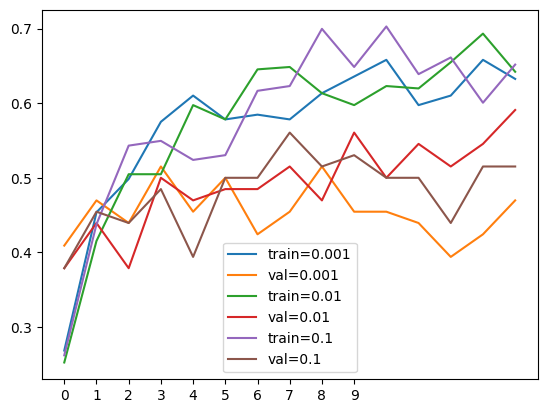

In [ ]:
#plot training and validation accuracy
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label='train=%s' % lr)
  plt.plot(hist['val_accuracy'], label='val=%s' % lr)
plt.xticks(np.arange(10))
plt.legend()

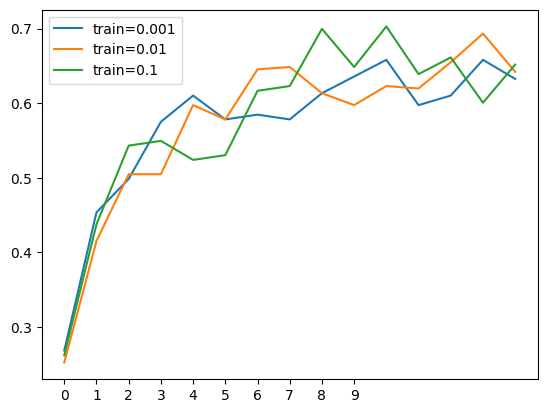

In [ ]:
#plot training accuracy
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label='train=%s' % lr)
plt.xticks(np.arange(10))
plt.legend()

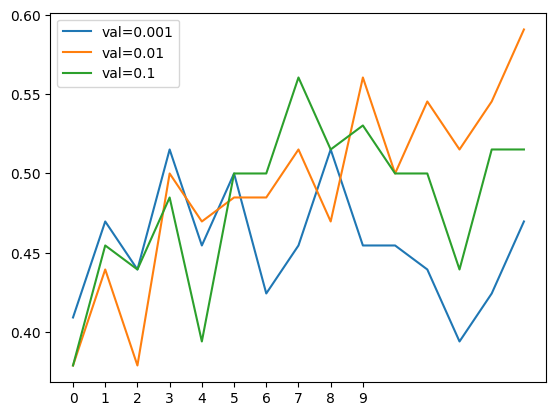

In [ ]:
#plot training and validation accuracy
for lr, hist in scores.items():
  plt.plot(hist['val_accuracy'], label='val=%s' % lr)
plt.xticks(np.arange(10))
plt.legend()

Based on the plot, I will choose learning_rate = 0.01

### Adding more layers

In [ ]:
def make_model(learning_rate=0.01, size_inner=10):
  ##############################
  #Architecture of model

  inputs = keras.Input(shape=(224, 224, 3))
  base = base_model(inputs, training = False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  outputs = keras.layers.Dense(7)(inner)
  model = keras.Model(inputs, outputs)

  ##############################

  learning_rate = 0.01
  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  loss= keras.losses.CategoricalCrossentropy(from_logits=True)
  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
      )
  return model

In [ ]:
scores = {}
for s in [10, 50, 100, 1000]:
  print(s)
  model = make_model(learning_rate=0.01, size_inner=s)
  history = model.fit(
      train_generator,
      epochs = 15,
      validation_data=val_generator)

  scores[s] = history.history

  print()
  print()

10
Epoch 1/15
16/16 [==============================] - 11s 464ms/step - loss: 2.2587 - accuracy: 0.2396 - val_loss: 1.7583 - val_accuracy: 0.2424
Epoch 2/15
16/16 [==============================] - 6s 355ms/step - loss: 1.8209 - accuracy: 0.2748 - val_loss: 1.7832 - val_accuracy: 0.2424
Epoch 3/15
16/16 [==============================] - 7s 418ms/step - loss: 1.7204 - accuracy: 0.3131 - val_loss: 1.6778 - val_accuracy: 0.2576
Epoch 4/15
16/16 [==============================] - 6s 356ms/step - loss: 1.6663 - accuracy: 0.3291 - val_loss: 1.6119 - val_accuracy: 0.2727
Epoch 5/15
16/16 [==============================] - 6s 360ms/step - loss: 1.6161 - accuracy: 0.3259 - val_loss: 1.5786 - val_accuracy: 0.3030
Epoch 6/15
16/16 [==============================] - 7s 450ms/step - loss: 1.5714 - accuracy: 0.3546 - val_loss: 1.5719 - val_accuracy: 0.3182
Epoch 7/15
16/16 [==============================] - 6s 388ms/step - loss: 1.5615 - accuracy: 0.3546 - val_loss: 1.5621 - val_accuracy: 0.3485
Ep

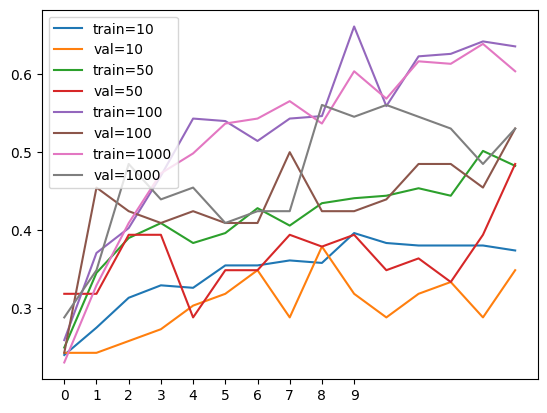

In [ ]:
#plot training and validation accuracy
for size, hist in scores.items():
  plt.plot(hist['accuracy'], label='train=%s' % size)
  plt.plot(hist['val_accuracy'], label='val=%s' % size)
plt.xticks(np.arange(10))
plt.legend()

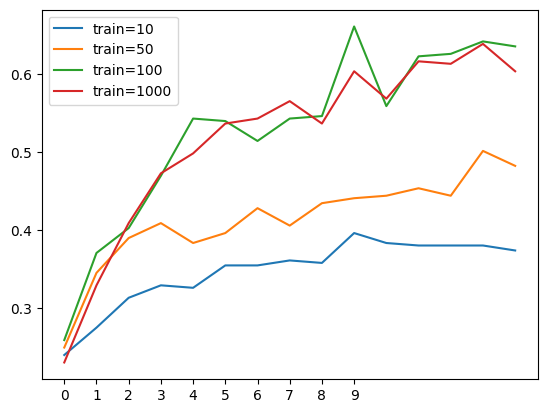

In [ ]:
#plot training accuracy
for size, hist in scores.items():
  plt.plot(hist['accuracy'], label='train=%s' % size)
plt.xticks(np.arange(10))
plt.legend()

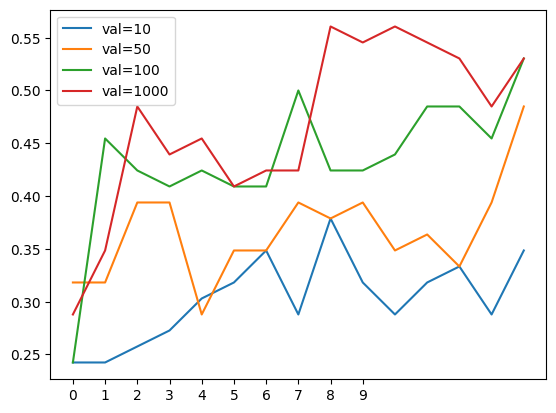

In [ ]:
for size, hist in scores.items():
  plt.plot(hist['val_accuracy'], label='val=%s' % size)
plt.xticks(np.arange(10))
plt.legend()

size = 50

## Droupout and Regularization

In [ ]:
def make_model(learning_rate=0.01, size_inner=50, droprate=0.2):
  ##############################
  #Architecture of model

  inputs = keras.Input(shape=(224, 224, 3))
  base = base_model(inputs, training = False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(droprate)(inner)
  outputs = keras.layers.Dense(7)(drop)
  model = keras.Model(inputs, outputs)

  ##############################

  learning_rate = 0.01
  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  loss= keras.losses.CategoricalCrossentropy(from_logits=True)
  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
      )
  return model

In [ ]:
learning_rate = 0.01
size = 50

scores={}

for droprate in [0.0, 0.2, 0.3, 0.5, 0.8]:
  print(droprate)

  model = make_model(
      learning_rate=learning_rate,
      size_inner=size,
      droprate=droprate)

  history = model.fit(train_generator, epochs = 15, validation_data=val_generator)
  scores[droprate] = history.history

  print()
  print()

0.0
Epoch 1/15
16/16 [==============================] - 12s 439ms/step - loss: 2.6943 - accuracy: 0.2332 - val_loss: 1.7399 - val_accuracy: 0.3333
Epoch 2/15
16/16 [==============================] - 8s 499ms/step - loss: 1.6536 - accuracy: 0.3482 - val_loss: 1.5710 - val_accuracy: 0.3636
Epoch 3/15
16/16 [==============================] - 6s 367ms/step - loss: 1.5252 - accuracy: 0.3482 - val_loss: 1.4908 - val_accuracy: 0.4545
Epoch 4/15
16/16 [==============================] - 8s 479ms/step - loss: 1.3753 - accuracy: 0.4441 - val_loss: 1.4834 - val_accuracy: 0.4697
Epoch 5/15
16/16 [==============================] - 6s 374ms/step - loss: 1.4256 - accuracy: 0.4728 - val_loss: 1.5538 - val_accuracy: 0.4545
Epoch 6/15
16/16 [==============================] - 7s 419ms/step - loss: 1.2878 - accuracy: 0.5080 - val_loss: 1.3676 - val_accuracy: 0.5000
Epoch 7/15
16/16 [==============================] - 6s 366ms/step - loss: 1.1883 - accuracy: 0.5687 - val_loss: 1.3926 - val_accuracy: 0.4545
E

will use droprate = 0.2

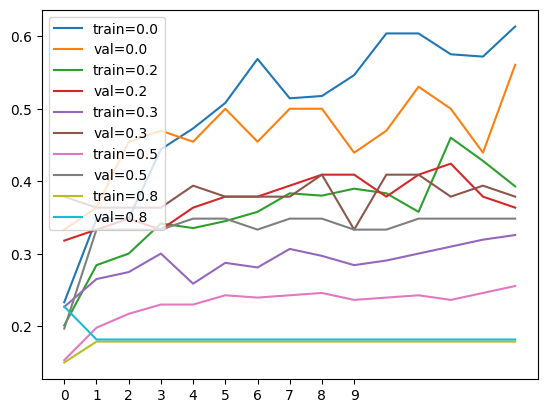

In [ ]:
#plot training and validation accuracy
for droprate, hist in scores.items():
  plt.plot(hist['accuracy'], label='train=%s' % droprate)
  plt.plot(hist['val_accuracy'], label='val=%s' % droprate)
plt.xticks(np.arange(10))
plt.legend()

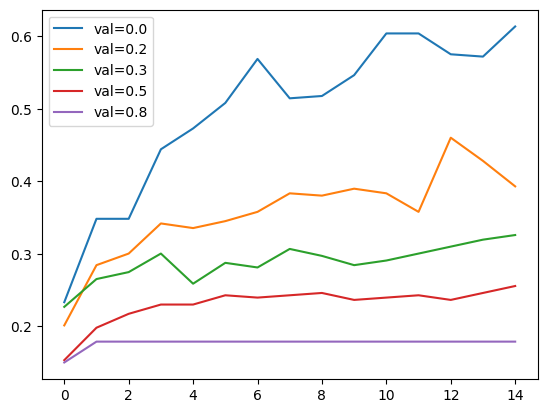

In [ ]:
#plot validation accuracy
for droprate, hist in scores.items():
  plt.plot(hist['accuracy'], label='val=%s' % droprate)

plt.legend()

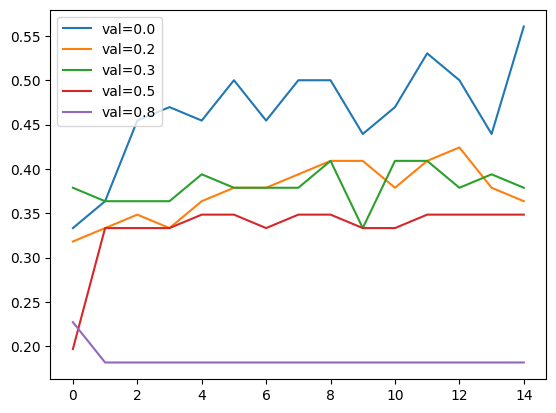

In [ ]:
#plot validation accuracy
for droprate, hist in scores.items():
  plt.plot(hist['val_accuracy'], label='val=%s' % droprate)

plt.legend()

## fully trained model

In [ ]:
input_size = 224
learning_rate = 0.01
size_inner = 50
droprate = 0.2

In [ ]:
def make_model(input_size = 224, learning_rate=0.01, size_inner=50, droprate=0.2):
  ##############################
  #Architecture of model

  inputs = keras.Input(shape=(input_size, input_size, 3))
  base = base_model(inputs, training = False)
  vectors = keras.layers.GlobalAveragePooling2D()(base)
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(droprate)(inner)
  outputs = keras.layers.Dense(7)(drop)
  model = keras.Model(inputs, outputs)

  ##############################

  learning_rate = 0.01
  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  loss= keras.losses.CategoricalCrossentropy(from_logits=True)
  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
      )
  return model

In [ ]:
#  to save the model
checkpoint = keras.callbacks.ModelCheckpoint(
    'mobilnetv2_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
    )

In [ ]:
model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size_inner,
    droprate=droprate)

history = model.fit(train_generator,
                    epochs = 50,
                    validation_data=val_generator,
                    callbacks=[checkpoint])



Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.5996 - accuracy: 0.2780

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 11s 423ms/step - loss: 2.5996 - accuracy: 0.2780 - val_loss: 1.8238 - val_accuracy: 0.3333
Epoch 2/50
16/16 [==============================] - 7s 457ms/step - loss: 1.7133 - accuracy: 0.3163 - val_loss: 1.6260 - val_accuracy: 0.3333
Epoch 3/50
16/16 [==============================] - 6s 370ms/step - loss: 1.6095 - accuracy: 0.3482 - val_loss: 1.5926 - val_accuracy: 0.3788
Epoch 4/50
16/16 [==============================] - 8s 513ms/step - loss: 1.5563 - accuracy: 0.3642 - val_loss: 1.5684 - val_accuracy: 0.4091
Epoch 5/50
16/16 [==============================] - 6s 370ms/step - loss: 1.5048 - accuracy: 0.3546 - val_loss: 1.6061 - val_accuracy: 0.4242
Epoch 6/50
16/16 [==============================] - 7s 450ms/step - loss: 1.5621 - accuracy: 0.3323 - val_loss: 1.5273 - val_accuracy: 0.4091
Epoch 7/50
16/16 [==============================] - 6s 357ms/step - loss: 1.4243 - accuracy: 0.4058 - val_loss: 1.4927 - val_accuracy: 0.3485
Epoch 8/50
16/16